In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import datetime

from googleapiclient.discovery import build
from IPython.display import Image, HTML, IFrame

In [3]:
MINDYOURDECISIONS = ['UCHnj59g7jezwTy5GeL8EA_g', 'MindYourDecisions']
BLACKPENREDPEN = ['UC_SvYP0k05UKiJ_2ndB02IA', 'blackpenredpen']
CHANNELS = [MINDYOURDECISIONS, BLACKPENREDPEN]

In [4]:
youtube = build('youtube','v3',developerKey=YT_API_KEY)

In [5]:
def get_thumbnail(channel_id):
    snippets = youtube.search().list(part="snippet", type="channel", q=channel_id).execute()
    
    return snippets['items'][0]['snippet']['thumbnails']['high']['url']

In [6]:
def basic_stats(channel_id):
    stats = youtube.channels().list(part="statistics", id=channel_id[0]).execute()

    df = pd.DataFrame({channel_id[1]: stats['items'][0]['statistics']})
    df = df.rename({'subscriberCount': 'Subscribers', 'videoCount': 'Videos', 'viewCount': 'Views'}, axis='rows')
    df = df.drop('hiddenSubscriberCount')
    
    return df

In [7]:
def basic_stats_combined(channels):
    df = pd.DataFrame()
    for channel in channels:
        stats = youtube.channels().list(part="statistics", id=channel[0]).execute()

        df[channel[1]] = stats['items'][0]['statistics'].values()
    df = df.rename({1: 'Subscribers', 3: 'Videos', 0: 'Views'}, axis='rows')
    df = df.drop(2)
    
    df = df.apply(pd.to_numeric)
    
    return df

In [8]:
df = basic_stats_combined(CHANNELS)

<h1 style=font-size:50px> Characterization </h1>

<h1> blackpen<font color='red'>redpen</font></h1>

This channel is about math for fun! Most of the topics will be calculus-based. Sometimes we will also investigate some weird equations and complex numbers! Blackpenredpen is a YouTube star and professor at Pierce College in Los Angeles, who runs a channel where he posts videos of himself solving mathematical problems, with a focus on calculus and solving integrals. He is known for having a number of characteristic catchphrases, such as "I don't like to be on the bottom; I like to be on top", when moving the imaginary unit number from the bottom to the top of a quotient expression.
The name of the channel comes from the colors he prefers for whiteboard markers in many of his videos, and as time went on and he progressed to more complex problems and other colored markers began to be necessitated, it became something of a running joke.


In [9]:
Image(url= get_thumbnail(BLACKPENREDPEN[0]), width=400, height=400)

In [10]:
basic_stats(BLACKPENREDPEN)

,blackpenredpen
Subscribers,807000
Videos,2388
Views,124673967


<h1> MindYourDecisions </h1>

He run the MindYourDecisions channel on YouTube, which has over 1 million subscribers and 200 million views. He is also the author of The Joy of Game Theory: An Introduction to Strategic Thinking, and several other books which are available on Amazon. By way of history, He started the Mind Your Decisions blog back in 2007 to share a bit of math, personal finance, personal thoughts, and game theory. It's been quite a journey! He studied Economics and Mathematics at Stanford University.

In [11]:
Image(url= get_thumbnail(MINDYOURDECISIONS[0]), width=400, height=400)

In [12]:
basic_stats(MINDYOURDECISIONS)

,MindYourDecisions
Subscribers,2520000
Videos,651
Views,355468696


# Comparision

-> bar ploty do tych tabelek

In [13]:
df = basic_stats_combined(CHANNELS)
df

,MindYourDecisions,blackpenredpen
Views,355468696,124673967
Subscribers,2520000,807000
Videos,651,2388


# Create dataframes with videos

In [14]:
def collect_all_videos(channel_id):
    content = youtube.channels().list(id=channel_id, part='contentDetails').execute()
    UploadId = content['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    
    all_videos = []
    nextPage_token=None
    
    while True:
        res = youtube.playlistItems().list(playlistId=UploadId, maxResults=50, part='snippet', pageToken=nextPage_token).execute()
        all_videos += res["items"]
        nextPage_token = res.get("nextPageToken")
        if nextPage_token is None:
            break
        
    return all_videos

In [15]:
def collect_all_video_info(all_videos):
    video_ids = list(map(lambda x:x["snippet"]["resourceId"]["videoId"], all_videos))
    
    information = []
    for i in range(0, len(video_ids), 40):
        res = youtube.videos().list(id=",".join(video_ids[i:i+40]),part="statistics").execute()
        information += res["items"]
        
    return information

In [16]:
def create_dataframe(all_videos, information):
    title, liked, disliked, views, url, comment, videoid, published, description = [], [], [], [], [], [], [], [], []
    
    for i in range(len(all_videos)):
        title.append((all_videos[i])["snippet"]["title"])
        published.append((all_videos[i])["snippet"]["publishedAt"])
        description.append((all_videos[i])["snippet"]["description"])
        liked.append((information[i])["statistics"]["likeCount"])
        disliked.append((information[i])["statistics"]["dislikeCount"])
        views.append((information[i])["statistics"]["viewCount"])
        videoid.append((all_videos[i])["snippet"]["resourceId"]["videoId"])
        if "commentCount" in information[i]["statistics"]:
            comment.append((information[i])["statistics"]["commentCount"])
        else:
            comment.append(0)
        
    data={"title": title,
          "liked": liked,
          "disliked": disliked,
          "views": views,
          "comment": comment,
          "videoid": videoid,
          "published": published,
          "video_description": description}
    
    df = pd.DataFrame(data)
    
    df['liked']=df['liked'].astype('int')
    df['disliked']=df['disliked'].astype('int')
    df['comment']=df['comment'].astype('int')
    df['views'] = df['views'].astype('int')
    df['published'] = df['published'].astype('datetime64[ns]')
    
    return df

In [17]:
def get_dataframe(channel_id):
    all_videos = collect_all_videos(channel_id)
    information = collect_all_video_info(all_videos)    
    df = create_dataframe(all_videos, information)
    
    return df

# Creating dataframe with uploaded videos for blackpen<font color='red'>redpen</font>

In [18]:
df_blackpenredpen = get_dataframe(BLACKPENREDPEN[0])

In [19]:
df_blackpenredpen

,title,liked,disliked,views,comment,videoid,published,video_description
0,An exponential equation inspired by x! = 3,1225,12,30399,86,hztqL8104d0,2021-11-12 15:01:28,"An ""integral equation"" inspired by x factorial..."
1,Precalculus teacher vs WolframAlpha student,6954,79,159490,598,s3w9ecPelqc,2021-11-04 12:49:24,The domain of a function is a big part of prec...
2,when calculus teachers don't think the derivat...,2593,37,96861,208,81TUEBG5rI0,2021-11-02 09:06:35,When calculus teachers don't think the derivat...
3,my all-in-one calculus question,6228,66,163624,340,X0zYYFgQ5z0,2021-10-21 09:45:53,"Want to learn more about calculus limits, deri..."
4,1+0+0+...=?,3214,68,94905,208,GM_wkJOBz9A,2021-10-14 07:55:58,Learn evaluating limits and indeterminate form...
...,...,...,...,...,...,...,...,...
2383,[ACCUPLACER] Arithmetic (Q1.) Official Practic...,512,10,91859,11,QpX-A_IUyhs,2013-01-18 00:52:46,ACCUPLACER (by College Board) is a standardize...
2384,[ACCUPLACER] Arithmetic (Q2.) Official Practic...,403,13,57686,15,OVvuw7jz6TU,2013-01-18 00:37:18,ACCUPLACER (by College Board) is a standardize...
2385,[ACCUPLACER] Arithmetic (Q3.) Official Practic...,368,14,49393,19,qViF-7zL5RQ,2013-01-18 00:20:11,ACCUPLACER (by College Board) is a standardize...
2386,[ACCUPLACER] Arithmetic (Q5.) Official Practic...,309,5,42707,20,Dd3biOP8okg,2013-01-17 23:54:13,ACCUPLACER (by College Board) is a standardize...


# Creating dataframe with uploaded videos for MindYourDecisions

In [20]:
df_mindyourdecisions = get_dataframe(MINDYOURDECISIONS[0])

In [21]:
df_mindyourdecisions

,title,liked,disliked,views,comment,videoid,published,video_description
0,A nice chord problem from Bangladesh!,4309,49,80912,559,a9u1pjsfJDs,2021-09-23 07:23:40,This problem is adapted from the 2021 Banglade...
1,Can you solve this tricky sum from Indonesia?,5824,76,118563,448,VO4QElbHv-0,2021-09-15 00:46:52,This one stumped me at first. Can you figure i...
2,Legendary time Albert Einstein gave homework help,6468,116,158217,400,bwHnXQ0cygg,2021-09-08 00:56:18,Imagine being stuck on a math problem and then...
3,Test so hard that students cried - Helen and I...,4434,187,164812,624,aqPnuvrm4go,2021-10-12 00:18:33,This is a tricky question from Singapore's PSL...
4,A beautiful formula - 'Cause I'm real,3664,228,116100,199,chUlt9CX1oE,2021-10-08 08:30:18,The imaginary number i is equal to the square ...
...,...,...,...,...,...,...,...,...
646,How Game Theory Solved a Religious Mystery,1852,618,199616,525,f4dA4BTv7KQ,2014-02-07 01:57:02,A man dies leaving insufficient funds for debt...
647,How to Win at Sports Betting Guaranteed,879,436,229001,165,4GSV6-5Rt-I,2014-01-24 21:39:52,"This video is only to highlight math, I don't ..."
648,Math Puzzle: Area of a Triangle,3001,94,161330,304,lWIBk2DZszQ,2013-12-23 00:29:38,"A right triangle has a hypotenuse of 3, and on..."
649,Proving pi is irrational (using high school le...,2208,256,218723,332,PgKmstECld0,2013-11-08 05:21:52,I did make one big typo/mistake in the video: ...


## When first video was published?

In [22]:
df_mindyourdecisions.sort_values(by=['published']).head(n=1)['published']

650   2013-10-23 17:46:22
Name: published, dtype: datetime64[ns]

In [23]:
df_blackpenredpen.sort_values(by=['published']).head(n=1)['published']

2387   2013-01-17 23:35:42
Name: published, dtype: datetime64[ns]

## Videos with the most views

In [24]:
ind = df_blackpenredpen.sort_values(by=['views'])['views'].index[-1]
vid = df_blackpenredpen.loc[ind]['videoid']

In [25]:
df_blackpenredpen.sort_values(by=['views'])['views'].iloc[-1]

6555258

In [26]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/%s?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>' % vid)

c:\users\dariu\appdata\local\programs\python\python37\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [27]:
ind = df_mindyourdecisions.sort_values(by=['views'])['views'].index[-1]
vid = df_mindyourdecisions.loc[ind]['videoid']

In [28]:
df_mindyourdecisions.sort_values(by=['views'])['views'].iloc[-1]

17729743

In [29]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/%s?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>' % vid)

## Number of videos in time

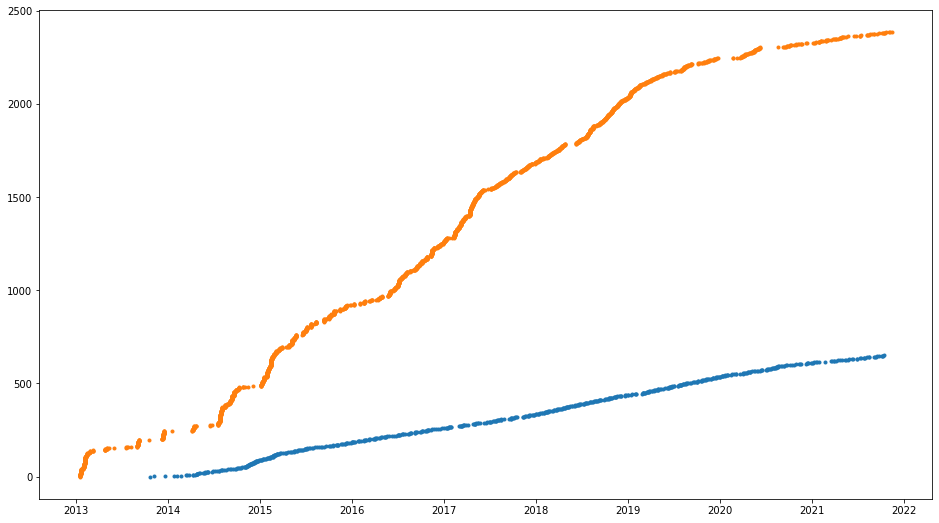

In [30]:
plt.figure(figsize=(16, 9))
plt.plot(df_mindyourdecisions.sort_values(by=['published'])['published'], range(0, 651), '.')
plt.plot(df_blackpenredpen.sort_values(by=['published'])['published'], range(0, 2388), '.')

## Distribution of views in videos

### MindYourDecisions

Text(0.5, 1.0, 'c')

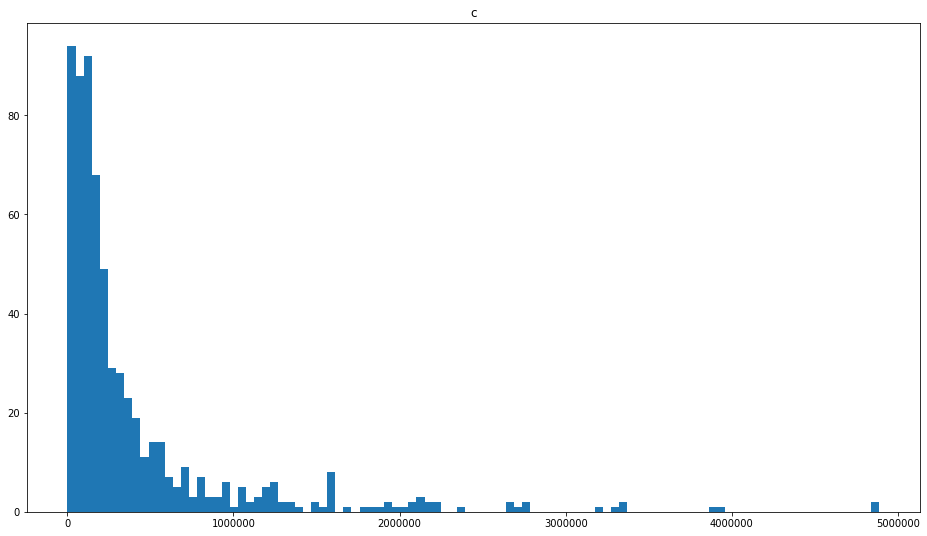

In [31]:
plt.figure(figsize=(16, 9))
plt.ticklabel_format(style='plain')
plt.hist(df_mindyourdecisions.sort_values(by=['views'])['views'][:-10], bins=100)
plt.title('c')

### blackpenredpen

Text(0.5, 1.0, 'c')

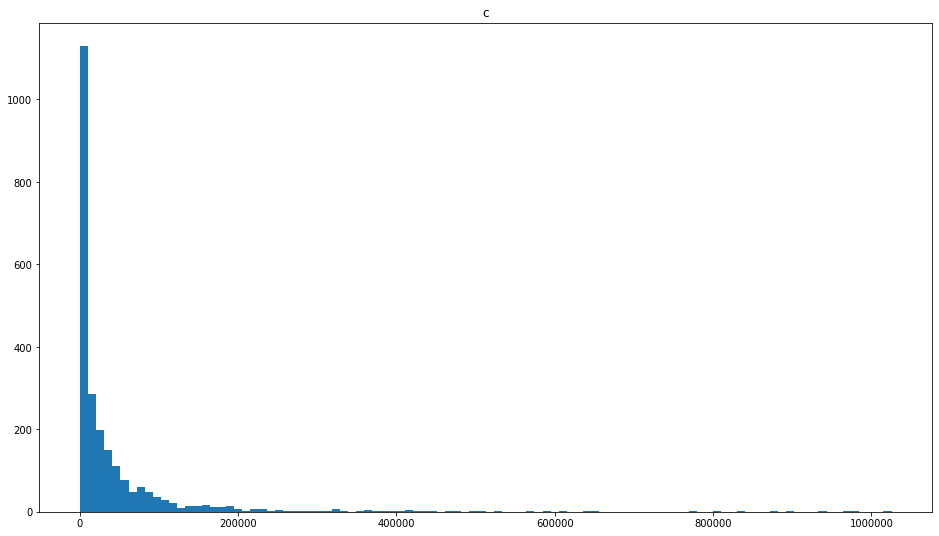

In [32]:
plt.figure(figsize=(16, 9))
plt.ticklabel_format(style='plain')
plt.hist(df_blackpenredpen.sort_values(by=['views'])['views'][:-10], bins=100)
plt.title('c')

## Distribution of ratio of likes/dislikes in videos

ratio = dislikes/sum(likes+dislikes)

In [33]:
df_blackpenredpen['likedratio'] = df_blackpenredpen['liked']/(df_blackpenredpen['liked']+df_blackpenredpen['disliked'])
df_blackpenredpen['dislikedratio'] = 1 - df_blackpenredpen['likedratio']

Text(0.5, 1.0, 'c')

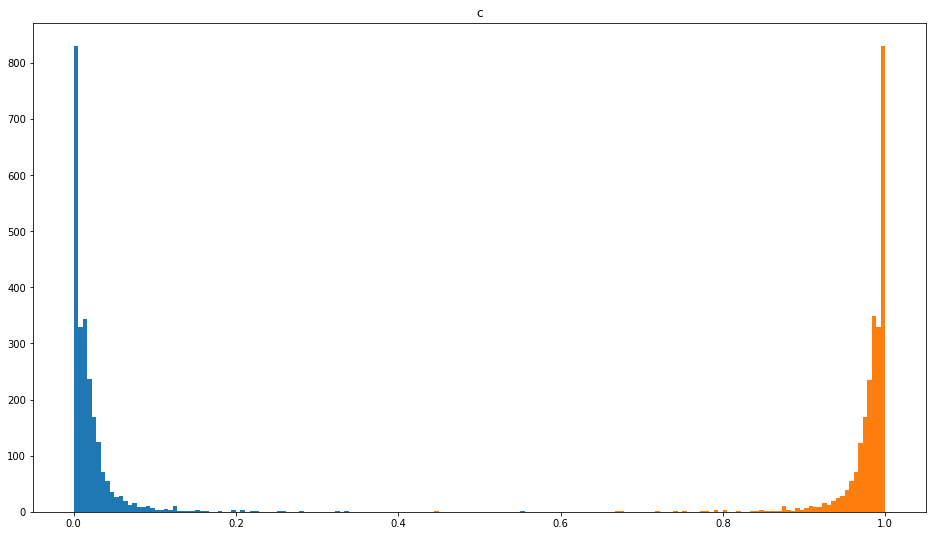

In [34]:
plt.figure(figsize=(16, 9))
plt.hist(df_blackpenredpen['dislikedratio'], bins=100)
plt.hist(df_blackpenredpen['likedratio'], bins=100)
plt.title('c')

In [35]:
df_mindyourdecisions['likedratio'] = df_blackpenredpen['liked']/(df_blackpenredpen['liked']+df_blackpenredpen['disliked'])
df_mindyourdecisions['dislikedratio'] = 1 - df_blackpenredpen['likedratio']

Text(0.5, 1.0, 'c')

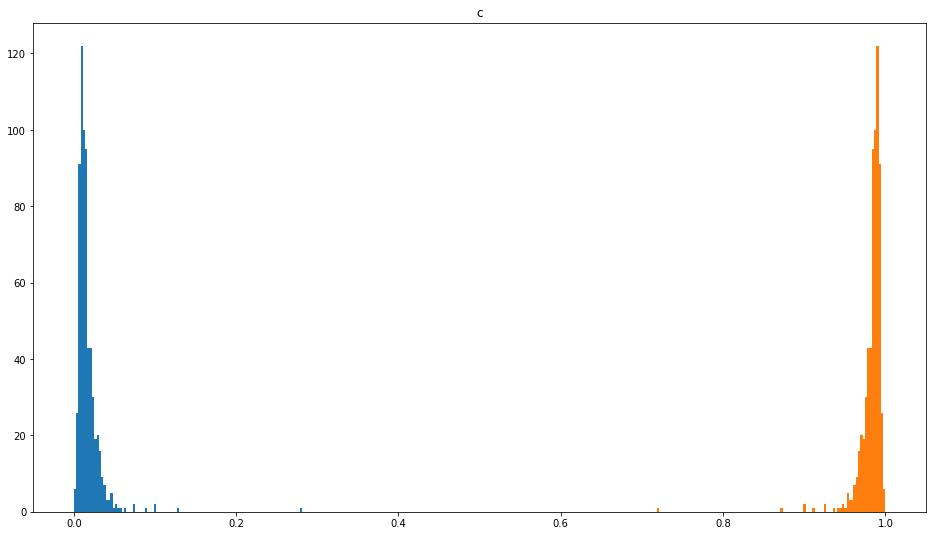

In [36]:
plt.figure(figsize=(16, 9))
plt.hist(df_mindyourdecisions['dislikedratio'], bins=100)
plt.hist(df_mindyourdecisions['likedratio'], bins=100)
plt.title('c')

## Number of views vs number of likes

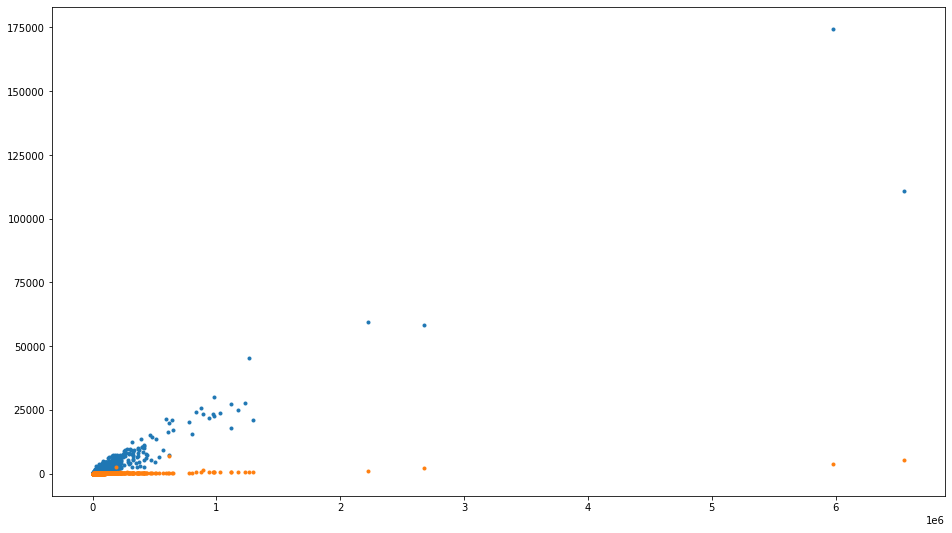

In [37]:
plt.figure(figsize=(16,9))
plt.plot(df_blackpenredpen['views'], df_blackpenredpen['liked'],'.')
plt.plot(df_blackpenredpen['views'], df_blackpenredpen['disliked'],'.')

(0.0, 5000.0)

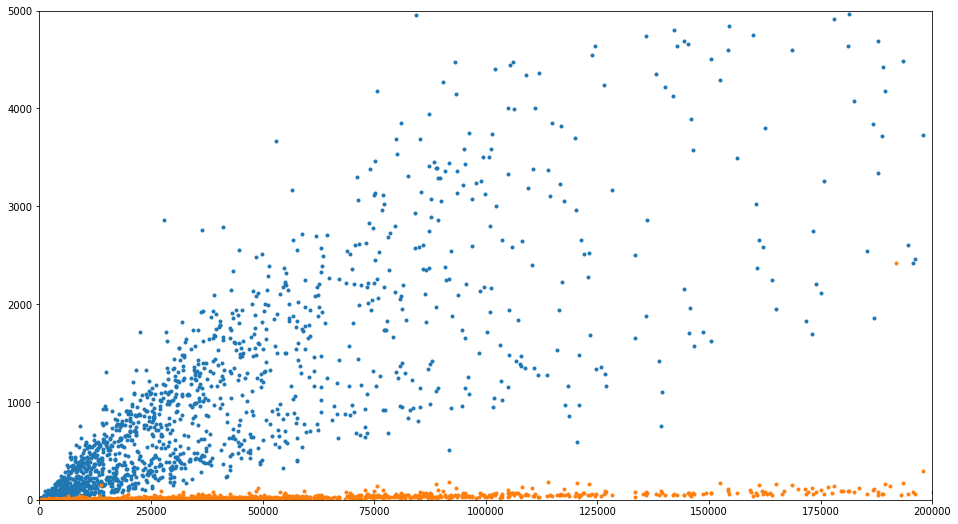

In [38]:
plt.figure(figsize=(16,9))
plt.plot(df_blackpenredpen['views'], df_blackpenredpen['liked'],'.')
plt.plot(df_blackpenredpen['views'], df_blackpenredpen['disliked'],'.')
plt.xlim([0, 200000])
plt.ylim([0, 5000])

(0.0, 5000.0)

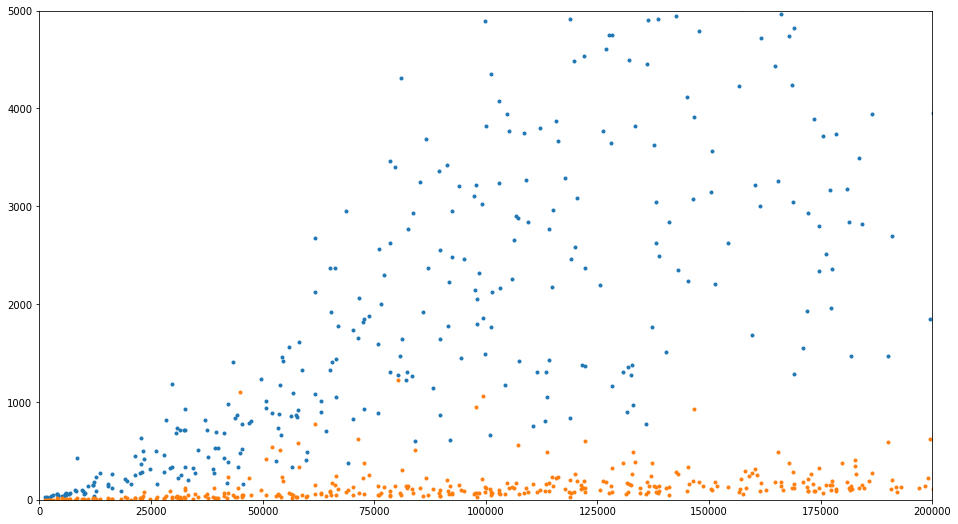

In [39]:
plt.figure(figsize=(16,9))
plt.plot(df_mindyourdecisions['views'], df_mindyourdecisions['liked'],'.')
plt.plot(df_mindyourdecisions['views'], df_mindyourdecisions['disliked'],'.')
plt.xlim([0, 200000])
plt.ylim([0, 5000])

## Number of views vs number of comments - regression 

(0.0, 2000.0)

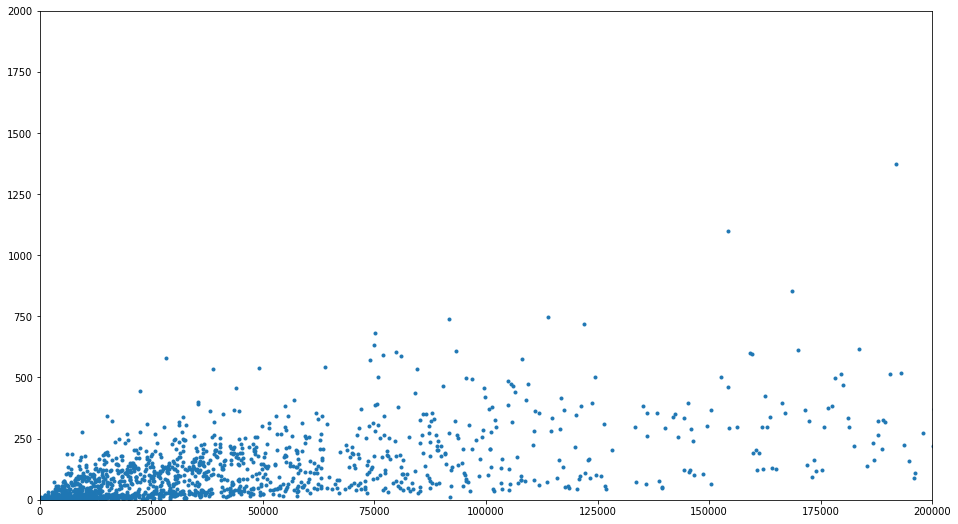

In [40]:
plt.figure(figsize=(16,9))
plt.plot(df_blackpenredpen['views'], df_blackpenredpen['comment'],'.')
plt.xlim([0, 200000])
plt.ylim([0, 2000])

## more dislikes ==?== more comments?

(0.0, 2000.0)

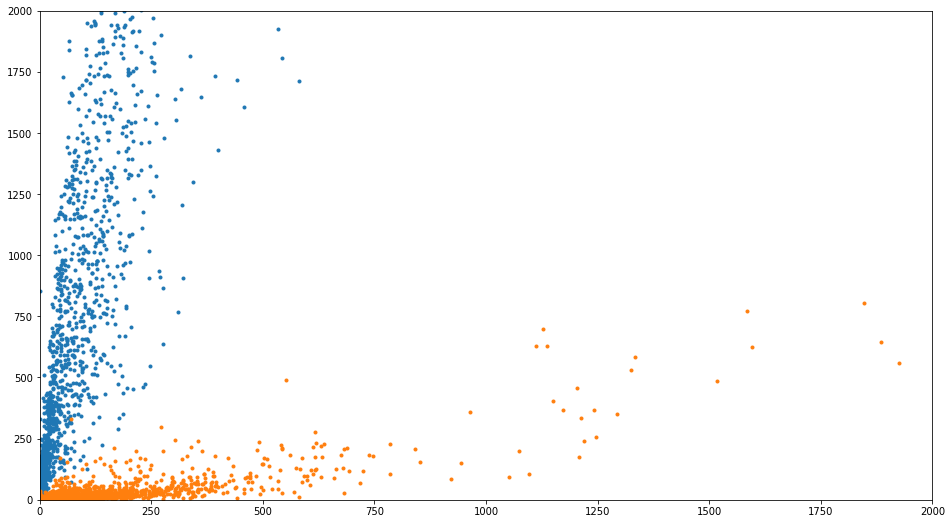

In [41]:
plt.figure(figsize=(16,9))
plt.plot(df_blackpenredpen['comment'], df_blackpenredpen['liked'],'.')
plt.plot(df_blackpenredpen['comment'], df_blackpenredpen['disliked'],'.')
plt.xlim([0, 2000])
plt.ylim([0, 2000])

Text(0.5, 1.0, 'Viewers who react on videos')

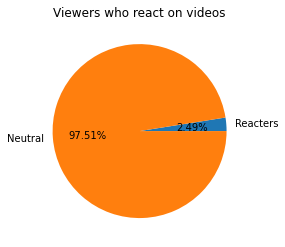

In [42]:
pie_vars = ['Reacters','Neutral']
pie_values = [df_blackpenredpen['liked'].sum()+df_blackpenredpen['disliked'].sum(),df_blackpenredpen['views'].sum()-(df_blackpenredpen['liked'].sum()+df_blackpenredpen['disliked'].sum())]
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%');
plt.title('Viewers who react on videos')

Text(0.5, 1.0, 'Viewers who react on videos')

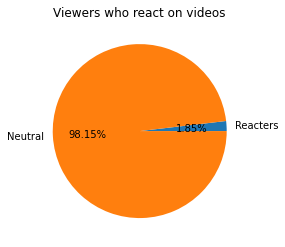

In [43]:
pie_vars = ['Reacters', 'Neutral']
pie_values = [df_mindyourdecisions['liked'].sum()+df_mindyourdecisions['disliked'].sum(),df_mindyourdecisions['views'].sum()-(df_mindyourdecisions['liked'].sum()+df_mindyourdecisions['disliked'].sum())]
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%');
plt.title('Viewers who react on videos')

Text(0.5, 1.0, 'Type of reacters')

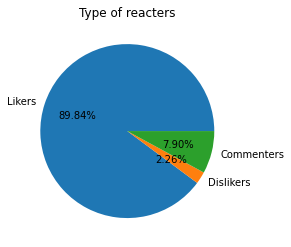

In [44]:
pie_vars = ['Likers', 'Dislikers', 'Commenters'];
pie_values = [df_blackpenredpen['liked'].sum(),df_blackpenredpen['disliked'].sum(),df_blackpenredpen['comment'].sum()]
plt.pie(pie_values,labels=pie_vars,autopct='%1.2f%%');
plt.title('Type of reacters')

Text(0.5, 1.0, 'Type of reacters')

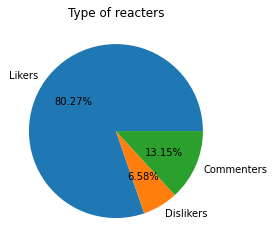

In [45]:
pie_vars = ['Likers', 'Dislikers', 'Commenters'];
pie_values = [df_mindyourdecisions['liked'].sum(),df_mindyourdecisions['disliked'].sum(),df_mindyourdecisions['comment'].sum()]
plt.pie(pie_values,labels=pie_vars,autopct='%1.2f%%');
plt.title('Type of reacters')

In [46]:
df=df_blackpenredpen.groupby(df_blackpenredpen['published'].dt.year).sum()

In [47]:
df.head(n=10)

,liked,disliked,views,comment,likedratio,dislikedratio
published,,,,,,
2013,15008,453,2068412,1387,241.248180,3.751820
2014,23914,1055,2696935,1360,233.700881,3.299119
2015,137766,4434,10999657,7680,428.771427,8.228573
2016,192946,4296,9911385,12613,329.799394,7.200606
2017,784136,32210,37907621,71037,417.367649,10.632351
2018,664994,13161,23452231,62683,339.563874,6.436126
2019,773570,13883,24833167,66878,209.246613,3.753387
2020,229532,3767,6986162,24039,79.843663,1.156337
2021,209571,3077,5909380,18798,60.239563,0.760437


In [48]:
df=df_blackpenredpen.groupby(df_blackpenredpen['published'].dt.year).count()
df1=df_mindyourdecisions.groupby(df_mindyourdecisions['published'].dt.year).count()

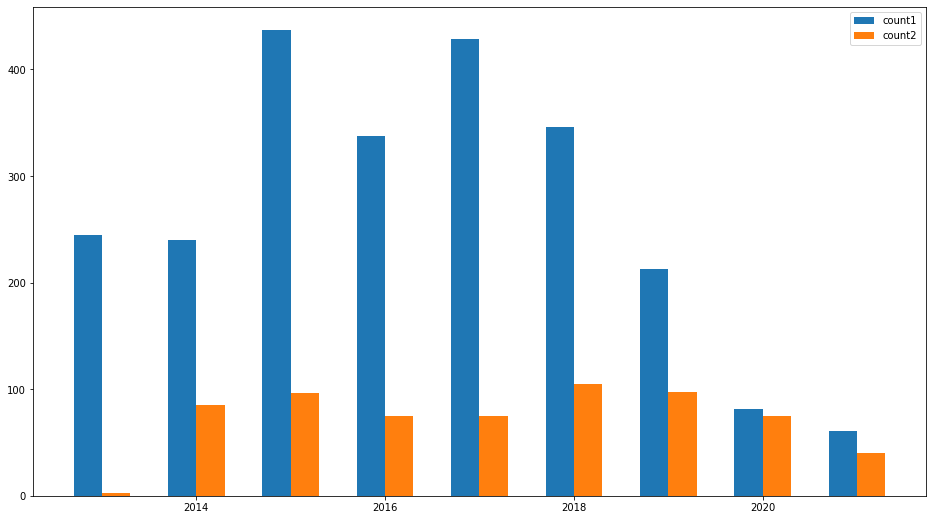

In [49]:
plt.figure(figsize=(16, 9))
plt.bar(range(2013,2022), df['published'], align='edge', width=-0.3, label='count1')
plt.bar(range(2013,2022), df1['published'], align='edge', width=0.3, label='count2')
plt.legend()

In [50]:
df=df_blackpenredpen.groupby(df_blackpenredpen['published'].dt.year).sum()
df1=df_mindyourdecisions.groupby(df_mindyourdecisions['published'].dt.year).sum()

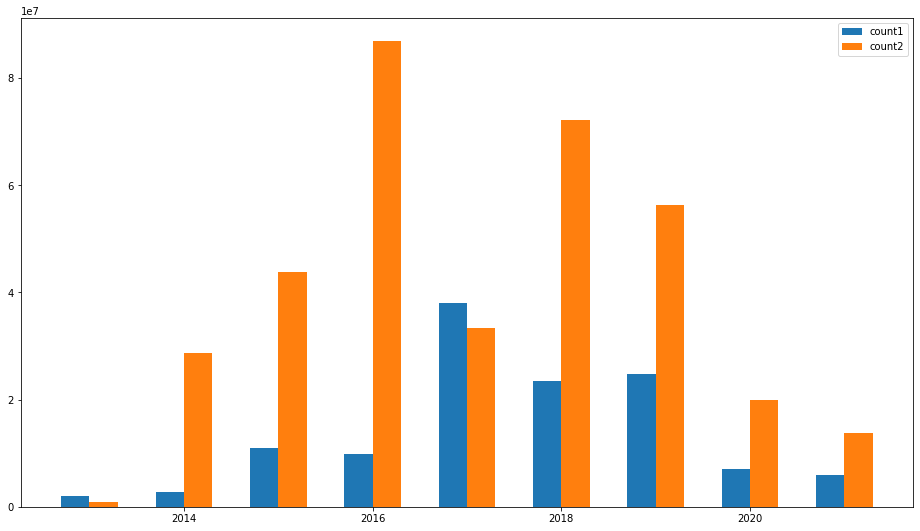

In [51]:
plt.figure(figsize=(16, 9))
plt.bar(range(2013,2022), df['views'], align='edge', width=-0.3, label='count1')
plt.bar(range(2013,2022), df1['views'], align='edge', width=0.3, label='count2')
plt.legend()

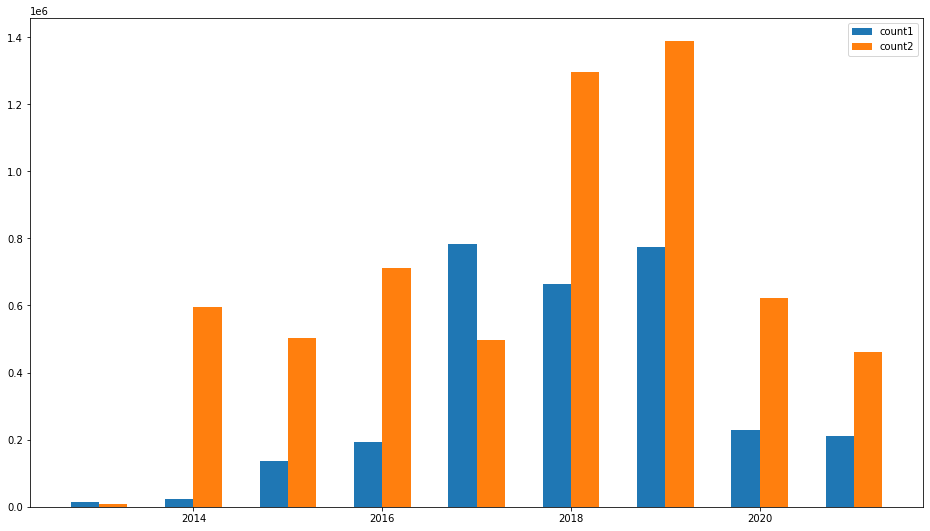

In [52]:
plt.figure(figsize=(16, 9))
plt.bar(range(2013,2022), df['liked'], align='edge', width=-0.3, label='count1')
plt.bar(range(2013,2022), df1['liked'], align='edge', width=0.3, label='count2')
plt.legend()

## Comments of my favourite video of blackpenredpen

In [60]:
vid = 'dgm4-3-Iv3s'

In [61]:
df_blackpenredpen[df_blackpenredpen['videoid'] == vid]

,title,liked,disliked,views,comment,videoid,published,video_description,likedratio,dislikedratio
280,100 INTEGRALS (in ONE take),174481,3618,5980544,10392,dgm4-3-Iv3s,2019-03-02 09:47:55,"100 integrals for calculus 1, calculus 2, and ...",0.979685,0.020315


In [69]:
print(df_blackpenredpen[df_blackpenredpen['videoid'] == vid]['video_description'].values[0])

100 integrals for calculus 1, calculus 2, and AP Calculus students. Integration techniques included: integration by parts, DI method, reverse power rule, u-substitution, trigonometric substitution, integration by substitution, integration by partial fraction decomposition, trigonometric integrals, and more. #calculus #微積分

😃 Update with Lars (stage 3 cancer survivor): https://youtu.be/LB1xWStHFPc  
😃 Try the problems first: https://bit.ly/100integrals
😃 Solutions by Jackw11111: https://bit.ly/100integralsol
😃 Calculus Finisher t-shirt: https://bit.ly/calcfinisher

Ultimate Integral Starter (learn all integral techniques): https://youtu.be/XOUwIdufY9Y
Check out my other "100-everything" playlist: https://bit.ly/100everything

Q1 to Q25, myself Hello: 0:00
1, Integral of tan^5(x)*sec^3(x), 2:19
2, Integral of cos(2x)/(sin(x)+cos(x)), 5:58
3, Integral of (x^2+1)/(x^4-x^2+1), 8:00
4, Integral of (x+e^x)^2, 12:00
5, Integral of csc^3(x)*sec(x), 14:00
6, Integral of cos(x)/(sin^2(x)-5sin(x)-

In [62]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/%s?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>' % vid)

c:\users\dariu\appdata\local\programs\python\python37\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
